# piecewise

## imports and device

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import pickle
import time
import matplotlib.pyplot as plt
import FINDER_core

Using cuda device for FINDER


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## dataset CIFAR10

In [ ]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


full_batch_size = len(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=full_batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=full_batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:18<00:00, 9180314.17it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## CNN class

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    def loss_grad(self, param, inputs, labels, no_grad = False):

        '''
        zeroeing gradients
        '''
        torch.nn.utils.vector_to_parameters(param, self.parameters())
        self.zero_grad(set_to_none=True)

        '''
        loss and grads
        '''
        outputs = model(inputs)

        if no_grad == False:
            ls = criterion(outputs, labels)
            ls.backward()
            grads = torch.cat([param.grad.data.view(-1) for param in self.parameters()], dim=0)
            return ls.detach().item(), grads

        else:
            with torch.no_grad():
                ls = criterion(outputs, labels)
                return ls.detach().item()

## create model and set loss_criteria

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
model = model.to(device)

In [ ]:
start = torch.nn.utils.parameters_to_vector(model.parameters())

In [ ]:
torch.nn.utils.vector_to_parameters(start, model.parameters())

In [ ]:
print(start.shape)

torch.Size([775190])


In [ ]:
for inputs, labels in trainloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    print(model.loss_grad(start, inputs, labels, no_grad=True))

2.3062424659729004


In [ ]:
optimizer = FINDER_core.FINDER(model, clamps = [0.001, 0.001])

## train loop with FINDER

In [ ]:
model.train()
tic = time.time()
loss_FINDER_cifar10 = []

for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        min_fitness = optimizer.step(inputs, labels)

        running_loss += min_fitness
    running_loss /= len(trainloader)

    loss_FINDER_cifar10.append(running_loss)
    print('Epoch [%d] loss: %.6f' %
          (epoch + 1, running_loss))

toc = time.time()
print("finished training in", toc - tic, "seconds")

Epoch [1] loss: 2.165060
Epoch [2] loss: 2.025023
Epoch [3] loss: 1.973791
Epoch [4] loss: 1.959236
Epoch [5] loss: 1.948124
Epoch [6] loss: 1.938210
Epoch [7] loss: 1.855616
Epoch [8] loss: 1.788688
Epoch [9] loss: 1.771489
Epoch [10] loss: 1.733082
Epoch [11] loss: 1.710443
Epoch [12] loss: 1.675512
Epoch [13] loss: 1.628614
Epoch [14] loss: 1.611186
Epoch [15] loss: 1.573863
Epoch [16] loss: 1.553810
Epoch [17] loss: 1.528636
Epoch [18] loss: 1.519854
Epoch [19] loss: 1.510188
Epoch [20] loss: 1.500505
Epoch [21] loss: 1.468480
Epoch [22] loss: 1.452147
Epoch [23] loss: 1.446736
Epoch [24] loss: 1.425997
Epoch [25] loss: 1.424762
Epoch [26] loss: 1.420488
Epoch [27] loss: 1.394870
Epoch [28] loss: 1.391473
Epoch [29] loss: 1.375377
Epoch [30] loss: 1.369018
Epoch [31] loss: 1.360022
Epoch [32] loss: 1.335897
Epoch [33] loss: 1.331584
Epoch [34] loss: 1.311764
Epoch [35] loss: 1.301750
Epoch [36] loss: 1.293967
Epoch [37] loss: 1.289102
Epoch [38] loss: 1.268393
Epoch [39] loss: 1.25

In [ ]:
torch.save(loss_FINDER_cifar10, 'cifar10_FINDER_N775190_fullbatch.pt')

## test accuracy

In [ ]:
# test accuracy

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on test set: {correct / total * 100} %")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4ee51f7490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Accuracy on test set: 60.940000000000005 %


## train accuracy

In [ ]:
# train accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy on test set: {correct / total * 100} %")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e4ee51f7490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Accuracy on test set: 71.52 %


# adam

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 14 * 14, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
torch.nn.utils.vector_to_parameters(start, net.parameters())
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_adam = []
print(torch.nn.utils.parameters_to_vector(net.parameters()).shape)

net.train()
tic = time.time()
for epoch in range(100):  # loop over the dataset multiple times
    correct = 0.0
    running_loss = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        net.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()

    running_loss /= len(trainloader)

    # print loss at the end of each epoch

    loss_adam.append(running_loss)

    print('Epoch [%d] loss: %.6f' %
          (epoch + 1, running_loss))
toc = time.time()
print('Finished Training in ', toc - tic, " seconds")

net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

net.eval()
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct / total))


torch.Size([775190])
Epoch [1] loss: 2.306950
Epoch [2] loss: 2.193794
Epoch [3] loss: 2.103122
Epoch [4] loss: 2.045482
Epoch [5] loss: 1.998375
Epoch [6] loss: 1.960468
Epoch [7] loss: 1.929970
Epoch [8] loss: 1.904383
Epoch [9] loss: 1.880977
Epoch [10] loss: 1.860894
Epoch [11] loss: 1.841209
Epoch [12] loss: 1.819179
Epoch [13] loss: 1.797470
Epoch [14] loss: 1.776903
Epoch [15] loss: 1.754947
Epoch [16] loss: 1.733545
Epoch [17] loss: 1.714817
Epoch [18] loss: 1.695902
Epoch [19] loss: 1.677599
Epoch [20] loss: 1.659931
Epoch [21] loss: 1.641483
Epoch [22] loss: 1.622921
Epoch [23] loss: 1.603551
Epoch [24] loss: 1.583729
Epoch [25] loss: 1.564438
Epoch [26] loss: 1.544565
Epoch [27] loss: 1.525349
Epoch [28] loss: 1.506822
Epoch [29] loss: 1.489080
Epoch [30] loss: 1.472578
Epoch [31] loss: 1.456955
Epoch [32] loss: 1.442382
Epoch [33] loss: 1.428139
Epoch [34] loss: 1.414337
Epoch [35] loss: 1.401019
Epoch [36] loss: 1.389506
Epoch [37] loss: 1.386256
Epoch [38] loss: 1.381075


In [ ]:
torch.save(loss_adam, 'cifar10_adam_N775190_fullbatch.pt')

# plotting

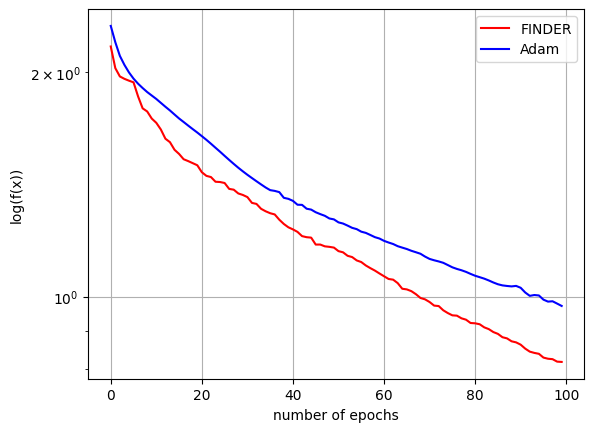

In [ ]:
ax = plt.axes()
# ax.set_facecolor('bisque')
plt.plot(loss_FINDER_cifar10,'r', label = "FINDER")
plt.plot(loss_adam,'b', label = "Adam")
plt.ylabel('log(f(x))')
plt.xlabel('number of epochs')
plt.legend()
plt.yscale('log')
plt.grid()